In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
plt.style.use('ggplot')

In [45]:
df = pd.read_csv('modeling_data.csv')
snap = pd.read_csv('snap.csv')
age = pd.read_csv('age.csv')
income = pd.read_csv('income.csv')

In [46]:
def extract_fips(x):
    x = str(x[-5:])
    return int(x)

In [47]:
snap = snap[['GEO_ID', 'NAME', "S2201_C01_001E", "S2201_C02_001E"]]
snap = snap.iloc[1:,:]
age = age[['GEO_ID', "B01002_001E"]]
age.columns = ['GEO_ID', "Median_Age"]
age = age.iloc[1:,:]
income = income[['GEO_ID', "B19001_001E"]]
income.columns = ['GEO_ID', "Median_Income"]
income = income.iloc[1:,:]
snap["p"] = snap["S2201_C02_001E"].astype(int)/snap["S2201_C01_001E"].astype(int)


snap["fips"] = snap["GEO_ID"].apply(lambda x: extract_fips(x))
age["fips"] = age["GEO_ID"].apply(lambda x: extract_fips(x))
income["fips"] = income["GEO_ID"].apply(lambda x: extract_fips(x))

In [48]:
slr_df = df.copy()
df = df.merge(snap, on="fips", how="left") \
            .merge(age, on="fips", how="left") \
            .merge(income, on="fips", how="left").dropna()

df["SNAP_Participation_Percentage"] = df.p*100

In [49]:
# correlations
df = df[["mortality", "value" , "SNAP_Participation_Percentage", "Median_Age", "Median_Income"]]
df.Median_Income = df.Median_Income.astype(int)
df.Median_Age = df.Median_Age.astype(float)
df.rename(columns = {"value": "Low_Access"}, 
          inplace = True)
df.corr()

,mortality,Low_Access,SNAP_Participation_Percentage,Median_Age,Median_Income
mortality,1.000000,-0.169911,0.503311,-0.030983,-0.133146
Low_Access,-0.169911,1.000000,-0.121703,0.032819,-0.145067
SNAP_Participation_Percentage,0.503311,-0.121703,1.000000,-0.074375,-0.075152
Median_Age,-0.030983,0.032819,-0.074375,1.000000,-0.104972
Median_Income,-0.133146,-0.145067,-0.075152,-0.104972,1.000000


In [55]:
# slr
slr_df.rename(columns = {"value": "Low_Access"}, 
          inplace = True)
res = smf.ols("mortality ~ Low_Access", data=slr_df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mortality   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     216.5
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.91e-47
Time:                        00:44:56   Log-Likelihood:                -17003.
No. Observations:                3140   AIC:                         3.401e+04
Df Residuals:                    3138   BIC:                         3.402e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    295.0376      1.489    198.082      0.000     292.117     297.958
Low_Access    -0.7060      0.048    -14.715      0.000      -0.800      -0.612
==============================================================================
Omnibus:                      123.155   Durbin-Watson:                   1.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              144.415
Skew:                           0.456   Prob(JB):                     4.37e-32
Kurtosis:                       3.523   Cond. No.                         47.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1


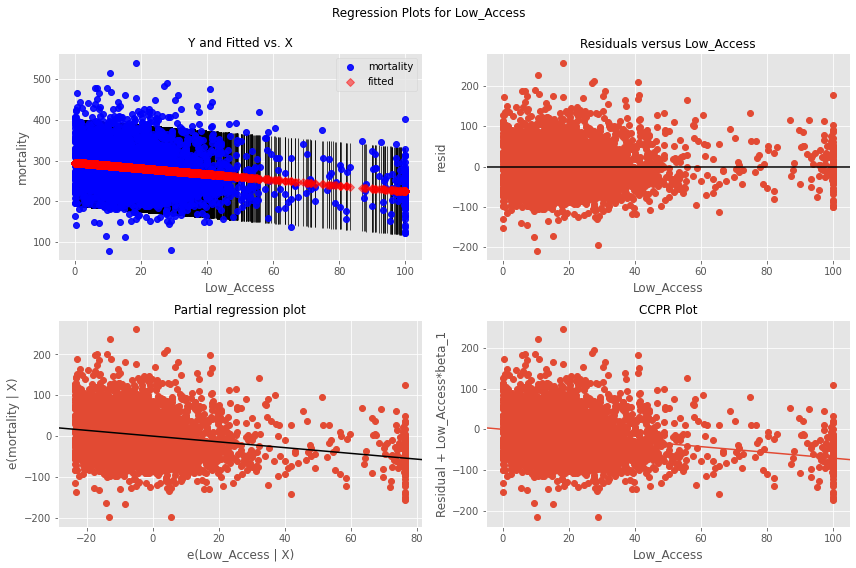

In [56]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(res, 'Low_Access', fig=fig)

In [52]:
# mlr
res = smf.ols("mortality ~ Low_Access + SNAP_Participation_Percentage + Median_Age+ Median_Income", data=temp).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mortality   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     77.32
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.77e-55
Time:                        00:42:04   Log-Likelihood:                -4077.4
No. Observations:                 807   AIC:                             8165.
Df Residuals:                     802   BIC:                             8188.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       229.5666     13.075     17.558      0.000     203.902     255.231
Low_Access                       -0.6177      0.147     -4.196      0.000      -0.907      -0.329
SNAP_Participation_Percentage     4.1004      0.261     15.717      0.000       3.588       4.613
Median_Age                       -0.0342      0.308     -0.111      0.912      -0.639       0.571
Median_Income                 -2.658e-05   7.01e-06     -3.791      0.000   -4.03e-05   -1.28e-05
==============================================================================
Omnibus:                        0.223   Durbin-Watson:                   1.212
Prob(Omnibus):                  0.895   Jarque-Bera (JB):                0.317
Skew:                           0.003   Prob(JB):                        0.853
Kurtosis:                       2.903   Cond. No.                     2.23e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

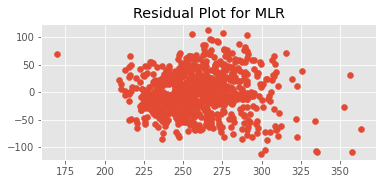

In [53]:
pred_val = res.fittedvalues.copy()
true_val = temp['mortality'].values.copy()
residual = true_val - pred_val
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(pred_val, residual)
plt.title("Residual Plot for MLR")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a805a7fe-fe3d-44c2-a936-f271a2a4c12f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>